# Python: Panel Data Introduction

In this example, we replicate the results from the guide [Getting Started with the did Package](https://bcallaway11.github.io/did/articles/did-basics.html) of the [did-R-package](https://bcallaway11.github.io/did/index.html).

The notebook requires the following packages:

In [5]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression

from doubleml.data import DoubleMLPanelData
from doubleml.did import DoubleMLDIDMulti

## Data

The data we will use is simulated and part of the [CSDID-Python-Package](https://d2cml-ai.github.io/csdid/index.html).

A description of the data generating process can be found at the [CSDID-documentation](https://d2cml-ai.github.io/csdid/examples/csdid_basic.html#Examples-with-simulated-data).


In [4]:
dta = pd.read_csv("https://raw.githubusercontent.com/d2cml-ai/csdid/main/data/sim_data.csv")
dta.head()

,G,X,id,cluster,period,Y,treat
0,3,-0.876233,1,5,1,5.562556,1
1,3,-0.876233,1,5,2,4.349213,1
2,3,-0.876233,1,5,3,7.134037,1
3,3,-0.876233,1,5,4,6.243056,1
4,2,-0.873848,2,36,1,-3.659387,1


To work with the [DoubleML-package](https://docs.doubleml.org/stable/index.html), we initialize a ``DoubleMLPanelData`` object.

Therefore, we set the *never-treated* units in group column `G` to `np.inf` (we have to change the datatype to `float`).

In [10]:
# set dtype for G to float
dta["G"] = dta["G"].astype(float)
dta.loc[dta["G"] == 0, "G"] = np.inf
dta.head()

,G,X,id,cluster,period,Y,treat
0,3.0,-0.876233,1,5,1,5.562556,1
1,3.0,-0.876233,1,5,2,4.349213,1
2,3.0,-0.876233,1,5,3,7.134037,1
3,3.0,-0.876233,1,5,4,6.243056,1
4,2.0,-0.873848,2,36,1,-3.659387,1


Now, we can initialize the ``DoubleMLPanelData`` object, specifying

 - `y_col` : the outcome
 - `d_cols`: the group variable indicating the first treated period for each unit
 - `id_col`: the unique identification column for each unit
 - `t_col` : the time column
 - `x_cols`: the additional pre-treatment controls


In [8]:
dml_data = DoubleMLPanelData(dta, y_col="Y", d_cols="G", id_col="id", t_col="period", x_cols=["X"])
print(dml_data)

================== DoubleMLPanelData Object ==================

------------------ Data summary      ------------------
Outcome variable: Y
Treatment variable(s): ['G']
Covariates: ['X']
Instrument variable(s): None
Time variable: period
Id variable: id
No. Observations: 3979

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15916 entries, 0 to 15915
Columns: 7 entries, G to treat
dtypes: float64(3), int64(4)
memory usage: 870.5 KB



## ATT estimation

In [14]:
dml_obj = DoubleMLDIDMulti(
    obj_dml_data=dml_data,
    ml_g=LinearRegression(),
    ml_m=LogisticRegression(),
    control_group="never_treated",
)

dml_obj.fit()
print(dml_obj)

================== DoubleMLDIDMulti Object ==================

------------------ Data summary      ------------------
Outcome variable: Y
Treatment variable(s): ['G']
Covariates: ['X']
Instrument variable(s): None
Time variable: period
Id variable: id
No. Observations: 3979

------------------ Score & algorithm ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0

------------------ Machine learner   ------------------
Learner ml_g: LinearRegression()
Learner ml_m: LogisticRegression()
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[1.42723659 1.40976728 1.39815026 1.42717567 1.40453859 1.42290288
  1.42334363 1.40484296 1.42488798]]
Learner ml_g1 RMSE: [[1.40243017 1.43571358 1.39765614 1.41559579 1.43028918 1.38457862
  1.4575677  1.41732542 1.40766147]]
Classification:
Learner ml_m Log Loss: [[0.69194005 0.69043888 0.69081606 0.67933534 0.67918078 0.67926994
  0.66255063 0.66234746 0.66203825]]

------------------ Resamp

As usual for the DoubleML-package, you can obtain joint confidence intervals via bootstrap.

In [17]:
level = 0.95

ci = dml_obj.confint(level=level)
dml_obj.bootstrap(n_rep_boot=5000)
ci_joint = dml_obj.confint(level=level, joint=True)
ci_joint

,2.5 %,97.5 %
"ATT(2.0,1,2)",0.742383,1.093789
"ATT(2.0,1,3)",1.811316,2.165366
"ATT(2.0,1,4)",2.783143,3.129410
"ATT(3.0,1,2)",-0.220600,0.141150
"ATT(3.0,2,3)",0.928564,1.286781
"ATT(3.0,2,4)",1.879972,2.238546
"ATT(4.0,1,2)",-0.186795,0.186935
"ATT(4.0,2,3)",-0.121916,0.242411
"ATT(4.0,3,4)",0.765324,1.134785


A visualization of the effects can be obtained via the `plot_effects()` method.

Remark that the plot used joint confidence intervals per default. 

/home/ubuntu/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/home/ubuntu/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


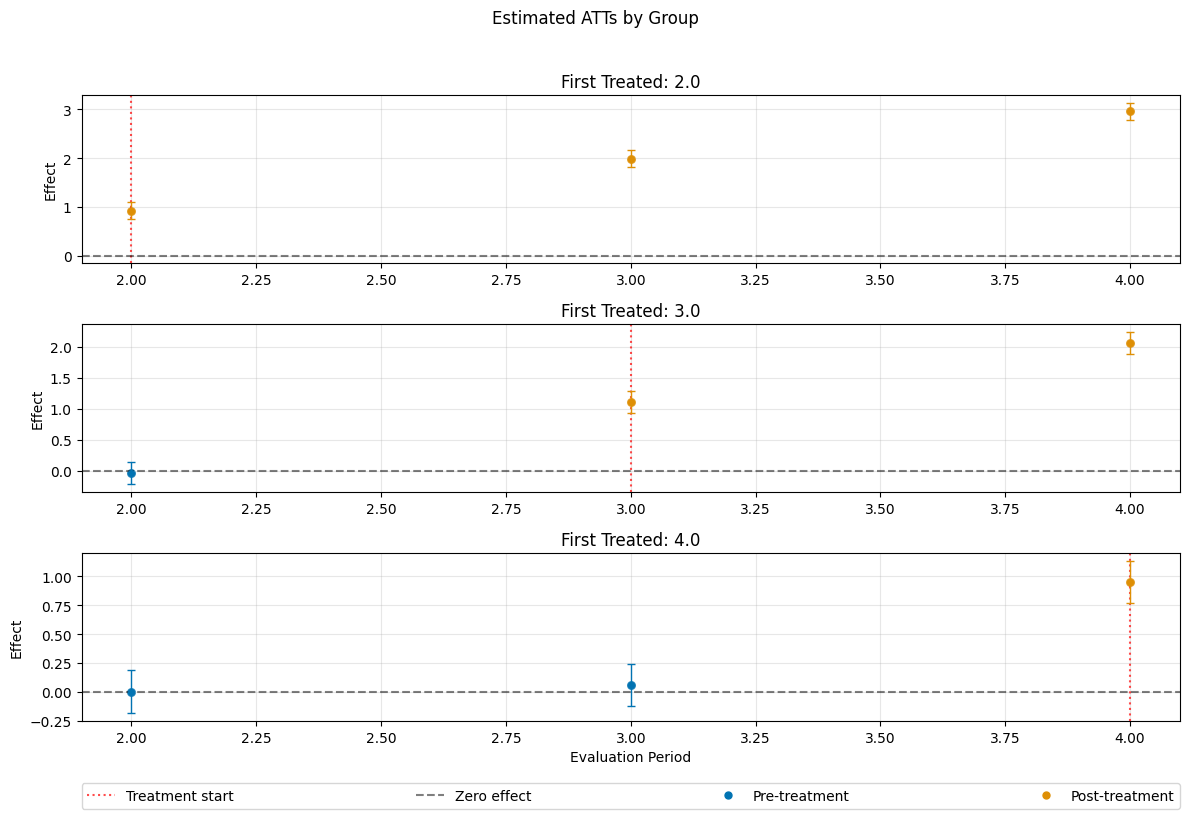

In [19]:
_ = dml_obj.plot_effects()

## Effect Aggregation

================== DoubleMLDIDAggregation Object ==================
 Group Aggregation 

------------------ Overall Aggregated Effects ------------------
    coef  std err         t  P>|t|    2.5 %   97.5 %
1.487145 0.034209 43.472838    0.0 1.420097 1.554192
------------------ Aggregated Effects         ------------------
         coef   std err          t  P>|t|     2.5 %    97.5 %
2.0  1.954235  0.052280  37.380505    0.0  1.851769  2.056701
3.0  1.583466  0.056236  28.157478    0.0  1.473245  1.693686
4.0  0.950055  0.067429  14.089722    0.0  0.817897  1.082213
------------------ Additional Information     ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0



/home/ubuntu/.venv/lib/python3.12/site-packages/doubleml/did/did_aggregation.py:328: UserWarning: Joint confidence intervals require bootstrapping which hasn't been performed yet. Automatically applying '.aggregated_frameworks.bootstrap(method="normal", n_rep_boot=500)' with default values. For different bootstrap settings, call bootstrap() explicitly before plotting.
  warnings.warn(


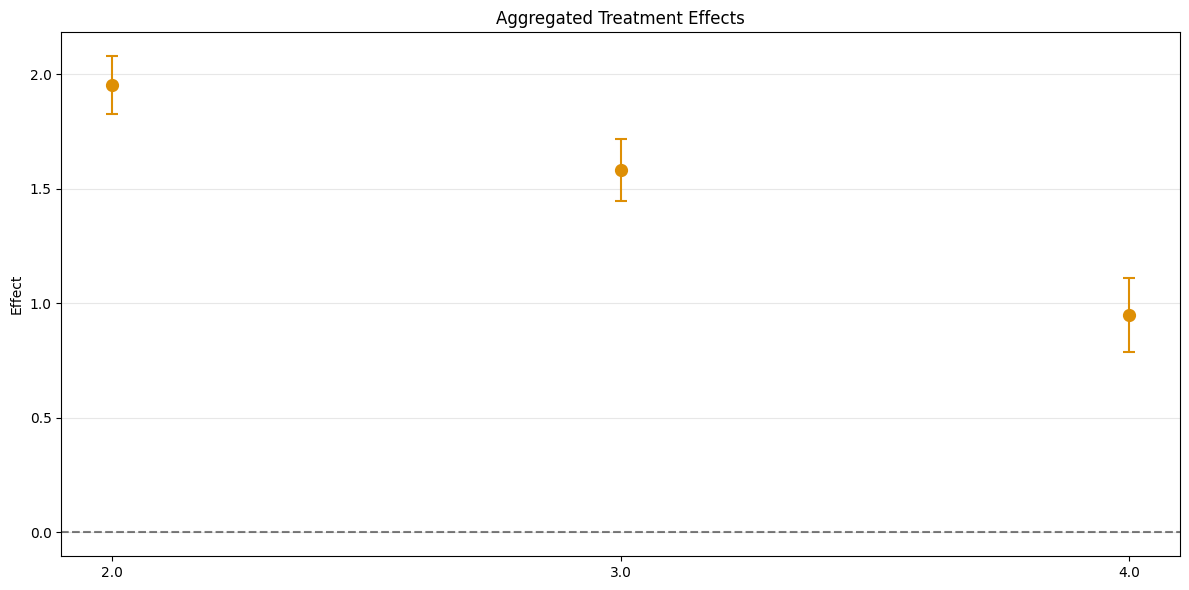

In [22]:
aggregated = dml_obj.aggregate("group")
print(aggregated)
_ = aggregated.plot_effects()

================== DoubleMLDIDAggregation Object ==================
 Time Aggregation 

------------------ Overall Aggregated Effects ------------------
    coef  std err         t  P>|t|    2.5 %   97.5 %
1.481664 0.035122 42.186396    0.0 1.412826 1.550501
------------------ Aggregated Effects         ------------------
       coef   std err          t  P>|t|     2.5 %    97.5 %
2  0.922607  0.064144  14.383278    0.0  0.796886  1.048328
3  1.550398  0.051377  30.177088    0.0  1.449701  1.651094
4  1.971986  0.046573  42.341923    0.0  1.880705  2.063267
------------------ Additional Information     ------------------
Control Group: never_treated
Anticipation Periods: 0
Score: observational



/home/ubuntu/.venv/lib/python3.12/site-packages/doubleml/did/did_aggregation.py:328: UserWarning: Joint confidence intervals require bootstrapping which hasn't been performed yet. Automatically applying '.aggregated_frameworks.bootstrap(method="normal", n_rep_boot=500)' with default values. For different bootstrap settings, call bootstrap() explicitly before plotting.
  warnings.warn(


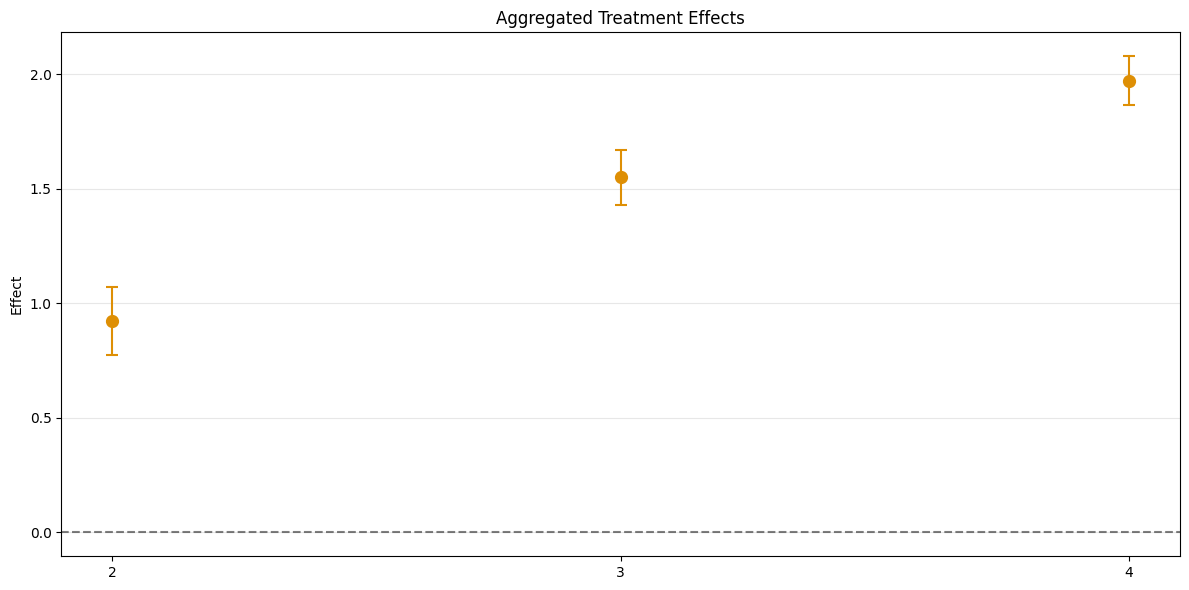

In [13]:
aggregated_time = dml_obj.aggregate("time")
print(aggregated_time)
fig, ax = aggregated_time.plot_effects()

================== DoubleMLDIDAggregation Object ==================
 Event Study Aggregation 

------------------ Overall Aggregated Effects ------------------
    coef  std err         t  P>|t|    2.5 %   97.5 %
1.991002 0.038754 51.376042    0.0 1.915046 2.066957
------------------ Aggregated Effects         ------------------
          coef   std err          t     P>|t|     2.5 %    97.5 %
-2.0  0.001911  0.068411   0.027932  0.977716 -0.132171  0.135993
-1.0  0.009913  0.040508   0.244708  0.806682 -0.069481  0.089306
0.0   0.992564  0.030753  32.274917  0.000000  0.932289  1.052840
1.0   2.025063  0.045671  44.340590  0.000000  1.935550  2.114576
2.0   2.955379  0.063298  46.689908  0.000000  2.831317  3.079441
------------------ Additional Information     ------------------
Control Group: never_treated
Anticipation Periods: 0
Score: observational



/home/ubuntu/.venv/lib/python3.12/site-packages/doubleml/did/did_aggregation.py:328: UserWarning: Joint confidence intervals require bootstrapping which hasn't been performed yet. Automatically applying '.aggregated_frameworks.bootstrap(method="normal", n_rep_boot=500)' with default values. For different bootstrap settings, call bootstrap() explicitly before plotting.
  warnings.warn(


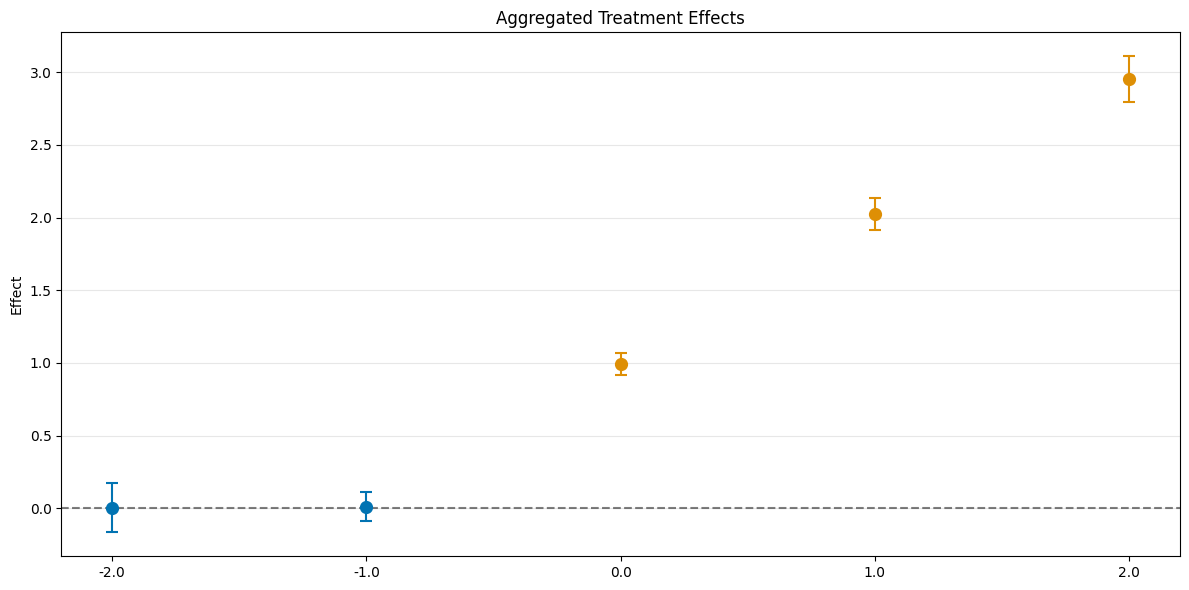

In [14]:
aggregated_eventstudy = dml_obj.aggregate("eventstudy")
print(aggregated_eventstudy)
fig, ax = aggregated_eventstudy.plot_effects()